In [3]:
import pandas as pd
import plotnine as p9
from mizani.formatters import comma_format

from db import con

In [4]:
# df = pd.read_sql("""
#     SELECT *  
#     FROM client__trips_all
#     WHERE 
#         UserRole != 'Maintenance'
#     """, con)

In [5]:
# df.head().transpose()

In [6]:
# df.shape

In [7]:
# df['CheckoutKioskName'].nunique(), df['ReturnKioskName'].nunique()

In [8]:
# del df

From the date of kiosk's first appearance -- profile plot of trip count versus time

In [9]:
df = pd.read_sql("""

    WITH date_spine AS (

        SELECT DISTINCT CheckoutDateLocal AS event_date 
        FROM client__trips_all
            
    )
                 
    , subjects AS (
    
        SELECT 
            CheckoutKioskName AS kiosk,
            MIN(CheckoutDateLocal) AS date_min,
            MAX(CheckoutDateLocal) AS date_max
                 
        FROM client__trips_all
        WHERE CheckoutKioskName IN (
            'Sabine Bridge', 'Crawford Island', 'La Branch & Lamar',
            'Hermann Park Lake Plaza', 'Lamar & Crawford'
            ) AND UserRole != 'Maintenance'
                 
        GROUP BY 1
    
    )
                 
    , panel_spine AS (
        
        SELECT
            kiosk, event_date
        FROM 
            date_spine
            CROSS JOIN subjects
        WHERE 
            event_date >= date_min
            AND event_date <= date_max
                 
    )
                 
    , originations AS (
    
        SELECT 
            CheckoutKioskName AS kiosk,
            CheckoutDateLocal AS event_date,
            COUNT(*) AS n_originations
            
        FROM client__trips_all
        WHERE UserRole != 'Maintenance'
        GROUP BY 1,2
    )
    
    /*
    , returns AS (
    
        SELECT 
            ReturnKioskName AS kiosk,
            ReturnDateLocal AS event_date,
            COUNT(*) AS n_returns
            
        FROM client__trips_all
        WHERE UserRole != 'Maintenance'
        GROUP BY 1,2
    )
    */
                 
    SELECT
        ps.kiosk,
        ps.event_date,
        ROW_NUMBER() OVER (PARTITION BY ps.kiosk ORDER BY ps.event_date) - 1
            AS days_since_open,
        COALESCE(o.n_originations, 0) AS n_originations,
        SUM(o.n_originations) OVER (
            PARTITION BY ps.kiosk
            ORDER BY ps.event_date
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            ) AS n_originations_since_open
    
    FROM
        panel_spine ps
        LEFT JOIN originations o
            ON o.event_date = ps.event_date
            AND o.kiosk = ps.kiosk
     
    """, con)

In [10]:
df['year'] = pd.to_datetime(df['event_date']).dt.year

In [11]:
df['event_date'].nunique(), df['kiosk'].nunique(), df.shape[0]

(3226, 5, 12303)

In [12]:
df

,kiosk,event_date,days_since_open,n_originations,n_originations_since_open,year
0,Crawford Island,2017-01-22 00:00:00,0,5,5,2017
1,Crawford Island,2017-01-23 00:00:00,1,3,8,2017
2,Crawford Island,2017-01-24 00:00:00,2,5,13,2017
3,Crawford Island,2017-01-25 00:00:00,3,16,29,2017
4,Crawford Island,2017-01-26 00:00:00,4,7,36,2017
...,...,...,...,...,...,...
12298,Sabine Bridge,2023-07-27 00:00:00,968,27,44723,2023
12299,Sabine Bridge,2023-07-28 00:00:00,969,18,44741,2023
12300,Sabine Bridge,2023-07-29 00:00:00,970,33,44774,2023
12301,Sabine Bridge,2023-07-30 00:00:00,971,40,44814,2023


In [13]:
df['n_originations_since_open'].describe()

count    12303.000000
mean     35247.434935
std      23360.560358
min          5.000000
25%      14700.500000
50%      32456.000000
75%      55789.500000
max      80280.000000
Name: n_originations_since_open, dtype: float64

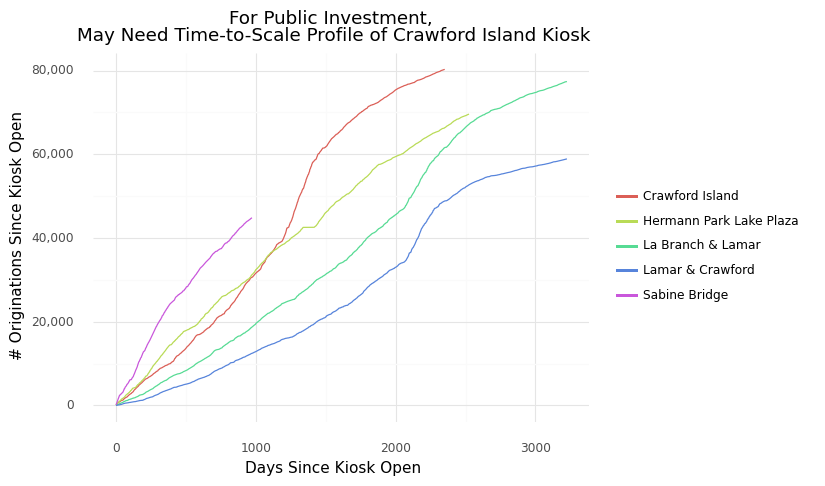

<ggplot: (161842037038)>

In [14]:
p = (
    p9.ggplot(df) + 
    p9.theme_minimal() + 
    p9.geom_line(p9.aes(
        'days_since_open', 'n_originations_since_open', 
        group='kiosk', color='kiosk'
        )) + 
    p9.scale_y_continuous(labels=comma_format()) + 
    p9.labs(
        y='# Originations Since Kiosk Open', x="Days Since Kiosk Open",
        color="",
        title="For Public Investment, \nMay Need Time-to-Scale Profile of Crawford Island Kiosk"
        )

)
p

In [15]:
p.save("originations_since_open.pdf")

c:\Users\alexa\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\alexa\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: originations_since_open.pdf


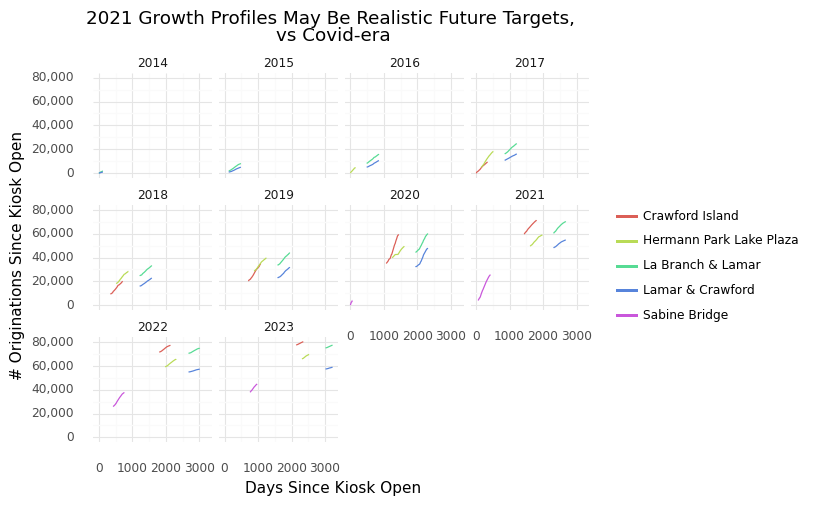

<ggplot: (161874796551)>

In [18]:
p = (
    p9.ggplot(df) + 
    p9.theme_minimal() + 
    p9.geom_line(p9.aes(
        'days_since_open', 'n_originations_since_open', 
        group='kiosk', color='kiosk'
        )) + 
    p9.scale_y_continuous(labels=comma_format()) + 
    p9.labs(
        y='# Originations Since Kiosk Open', x="Days Since Kiosk Open", color="",
        title="2021 Growth Profiles May Be Realistic Future Targets, \nvs Covid-era"
        ) + 
    p9.facet_wrap('year')

)
p

In [19]:
p.save("originations_since_open_by_year.pdf")

c:\Users\alexa\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\alexa\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: originations_since_open_by_year.pdf
